<a href="https://colab.research.google.com/github/yashgupta-7/legendre-forecasters/blob/main/lmu/Legendre_Memory_Unit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nengolib

     |████████████████████████████████| 122kB 17.1MB/s 
     |████████████████████████████████| 378kB 28.5MB/s 


In [ ]:
import torch
import torch.nn as nn
from sympy.matrices import Matrix, eye, zeros, ones, diag, GramSchmidt
import numpy as np
from functools import partial
import torch.nn.functional as F
import math

from nengolib.signal import Identity, cont2discrete
from nengolib.synapses import LegendreDelay
from functools import partial
def initerunif(tensor):
    fin = nn.init._calculate_correct_fan(tensor, 'fan_in')
    nn.init.uniform_(tensor, -math.sqrt(3 / fin), math.sqrt(3 / fin))

In [ ]:
class SingleLMUcell(nn.Module):
  def __init__(self, input_dim, units , order, theta, include_bias=False):
                #  hidden_kernel_initializer=torch.nn.init.uniform_,
                 #include_bias=False, #added by ali acc to branch):
    super(SingleLMUcell, self).__init__()

    self.order = order
    self.theta = theta
    self.units = units
    self.include_bias=include_bias

    realizer = Identity()
    self._realizer_result = realizer(LegendreDelay(theta=theta, order=self.order))

    self._ss = cont2discrete(self._realizer_result.realization, dt=1., method='zoh')

    self._A = self._ss.A - np.eye(order)
    self._B = self._ss.B
    self._C = self._ss.C

    self.AT = nn.Parameter(torch.Tensor(self._A), requires_grad=False)
    self.BT = nn.Parameter(torch.Tensor(self._B), requires_grad=False)

    if self.include_bias:
      self.bias = nn.Parameter(torch.Tensor(1, self.units),requires_grad=True) #added by ali for the fix given in github issue
    self.kernel_input = nn.Parameter(torch.Tensor(self.units, input_dim), requires_grad=True)
    self.kernel_memory = nn.Parameter(torch.Tensor(self.units, self.order), requires_grad=True)
    self.kernel_hidden = nn.Parameter(torch.Tensor(self.units, self.units), requires_grad=True)
    self.encoder_memory = nn.Parameter(torch.Tensor(1,self.order ), requires_grad=True)
    self.encoder_input = nn.Parameter(torch.Tensor(1,input_dim), requires_grad=True)
    self.encoder_hidden = nn.Parameter(torch.Tensor(1,self.units), requires_grad=True)
    
    
    if self.include_bias:
      torch.nn.init.constant_(self.bias, 0)

    initerunif(self.encoder_input)
    initerunif(self.encoder_hidden)
    initerunif(self.encoder_memory)
    torch.nn.init.xavier_normal_(self.kernel_input)
    torch.nn.init.xavier_normal_(self.kernel_hidden)
    torch.nn.init.xavier_normal_(self.kernel_memory)

  def EulerOdeSolver(self):
    A_hat = (self.step_delta_t/self.theta)*self.AT + torch.eye(self.order,self.d_order_ode)
    B_hat = (self.step_delta_t/self.theta)*self.BT

    return A_hat, B_hat

  def forward(self, inp, states):
    hidden, memory = states
    temp_u = F.linear(inp, self.encoder_input)+F.linear(hidden, self.encoder_hidden)+  F.linear(memory, self.encoder_memory)
    memory = memory + F.linear(memory, self.AT) + F.linear(temp_u, self.BT)
    hidden = nn.Tanh()(F.linear(inp, self.kernel_input) + F.linear(hidden, self.kernel_hidden) + F.linear(memory, self.kernel_memory)+(self.bias if self.include_bias else 0))
    
    return hidden, (hidden, memory)

class LMUBlock(nn.Module):
  def __init__(self, input_dim, units , order, theta):
    super(LMUBlock, self).__init__()
    self.units = units
    self.ord_of_poly = order
    self.lmucell = SingleLMUcell(input_dim, units , order, theta,include_bias=False)

  def forward(self, inp):
    outs = []
    memory_init = torch.zeros(inp.size(0),self.ord_of_poly).cuda()
    hidden_init = torch.zeros(inp.size(0),self.units).cuda()
    states = (hidden_init,memory_init)
    for i in range(inp.size(1)):
      out_curr, states = self.lmucell(inp[:,i,:], states)
      outs = outs+ [out_curr]
    retval=torch.stack(outs).permute(1,0,2)
    return retval, states
    # return torch.stack(outputs).permute(1,0,2), states


In [ ]:
class LMUFull(nn.Module):
  def __init__(self):
    super(LMUFull, self).__init__()
    self.LMU = LMUBlock(1,49,4,4)
    self.dense = nn.Linear(49,1)

  def forward(self,x):
    x, _ = self.LMU(x)
    x = self.dense(x)

    return x

model_lstm = LMUFull()




number of parameters :  2750



In [ ]:
class LSTMModel(nn.Module):
  def __init__(self):
    super(LSTMModel, self).__init__()
    self.LSTM = nn.LSTM(1,25,1,batch_first=True)
    self.dense = nn.Linear(25,1)

  def forward(self,x):
    x, _ = self.LSTM(x)
    x = self.dense(x)

    return x
    
model_lstm = LSTMModel()



Nombre de paramètres :  2826



(64, 5000, 1) (64, 5000, 1)


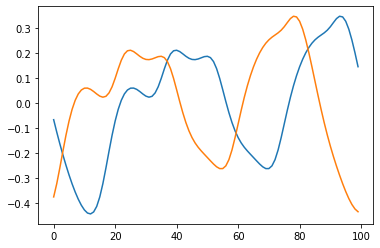

In [ ]:
import collections 
import matplotlib.pyplot as plt

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, RNN
from keras.initializers import RandomUniform
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from torchsummary import summary

def mackey_glass(sample_len=1000, tau=17, delta_t=10, seed=None, n_samples=1):
    # Adapted from https://github.com/mila-iqia/summerschool2015/blob/master/rnn_tutorial/synthetic.py
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples

def generate_data(n_batches, length, split=0.5, seed=0,
                  predict_length=15, tau=17, washout=100, delta_t=1,
                  center=True):
    X = np.asarray(mackey_glass(
        sample_len=length+predict_length+washout, tau=tau,
        seed=seed, n_samples=n_batches))
    X = X[:, washout:, :]
    cutoff = int(split*n_batches)
    if center:
        X -= np.mean(X)  # global mean over all batches, approx -0.066
    Y = X[:, predict_length:, :]
    X = X[:, :-predict_length, :]
    assert X.shape == Y.shape
    return ((X[:cutoff], Y[:cutoff]),
            (X[cutoff:], Y[cutoff:]))

(train_X, train_Y), (test_X, test_Y) = generate_data(128, 5000)
print(train_X.shape, test_X.shape)

def cool_plot(X, Y, title=""):
    plt.figure(figsize=(14, 8))
    plt.title(title)
    plt.scatter(X[:, 0], Y[:, 0] - X[:, 0], s=8, alpha=0.7,
                c=np.arange(X.shape[0]), cmap=sns.cubehelix_palette(as_cmap=True))
    plt.plot(X[:, 0], Y[:, 0] - X[:, 0], c='black', alpha=0.2)
    plt.xlabel("$x(t)$")
    plt.ylabel("$y(t) - x(t)$")
    sns.despine(offset=15)
    
    plt.show()

# cool_plot(train_X[0], train_Y[0])

plt.plot(train_X[0][0:100])
plt.plot(train_Y[0][0:100])
plt.show()



In [ ]:
def train(model, epochs, dataset, dataset_valid = None):
  for e in range(epochs):
      model.train()
      running_loss = 0
      with tqdm(total=len(dataset)) as bar:
        for i, (X, y) in enumerate(dataset):
            optimizer.zero_grad()
            
            output = model(X.cuda())

            loss_ll = criterion(output, y.cuda())
            
            loss_ll.backward()
            
            optimizer.step()
            
            running_loss += loss_ll.item()

            bar.update(1)
            bar.set_description("Epoch {} - Training loss: {}".format(e, running_loss/len(dataset)))

      model.eval()
      running_loss = 0
      outs = []
      with tqdm(total=len(dataset_valid)) as bar:
        for i, (X, y) in enumerate(dataset_valid):
            optimizer.zero_grad()
            
            output = model(X.cuda())
            t1=output.detach().cpu().numpy()[0][-100:]
            t2=y.detach().cpu().numpy()[0][-100:]
            loss_ll = criterion(output, y.cuda())
            
            running_loss += loss_ll.item()
            
            outs.append(output)
            bar.update(1)
            bar.set_description("Epoch {} - Validation loss: {}".format(e, running_loss/len(dataset_valid)))
      plt.plot(t1)
      plt.plot(t2)
      plt.show()


  0%|          | 0/2 [00:00<?, ?it/s]



umber of paramaters :  2750





Epoch 0 - Validation loss: 0.03585129790008068: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


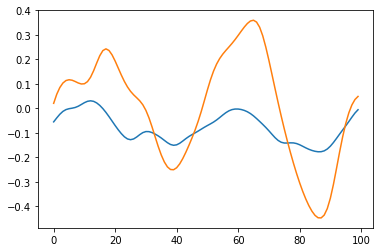

Epoch 1 - Validation loss: 0.024925326462835073: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


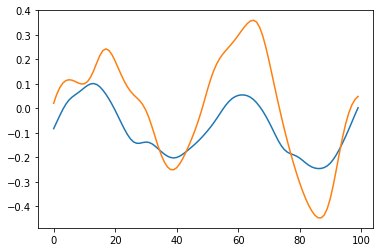

Epoch 2 - Validation loss: 0.018068441189825535: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


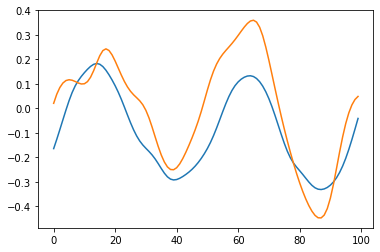

Epoch 3 - Validation loss: 0.01999821700155735: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


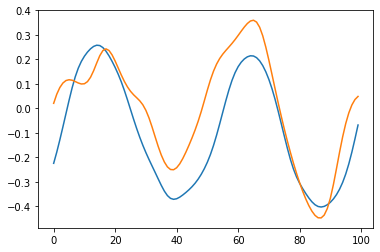

Epoch 4 - Validation loss: 0.021717614494264126: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


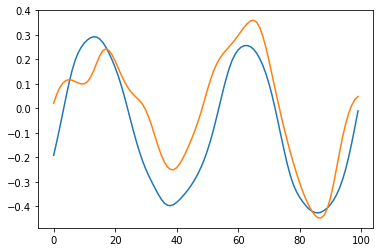

Epoch 5 - Validation loss: 0.019825680181384087: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


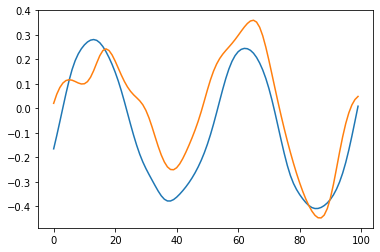

Epoch 6 - Validation loss: 0.016666398849338293: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


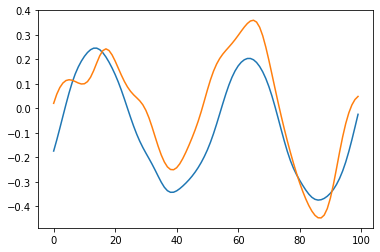

Epoch 7 - Validation loss: 0.015879131853580475: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


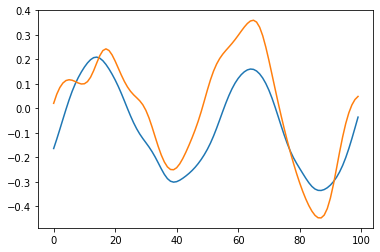

Epoch 8 - Validation loss: 0.015942348167300224: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


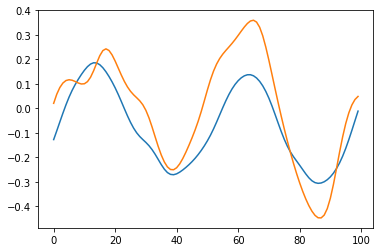

Epoch 9 - Validation loss: 0.01635822094976902: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


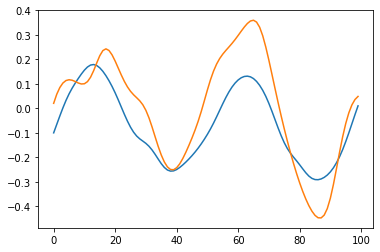

Epoch 10 - Validation loss: 0.015812872909009457: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


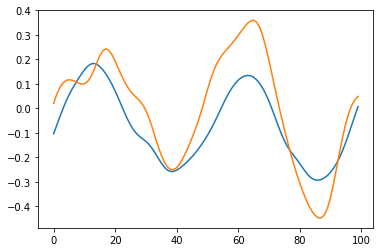

Epoch 11 - Validation loss: 0.014851954532787204: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


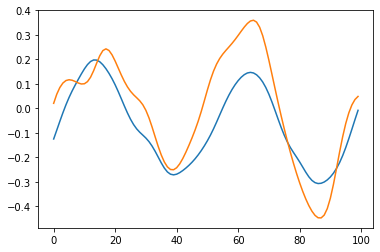

Epoch 12 - Validation loss: 0.013902651611715555: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


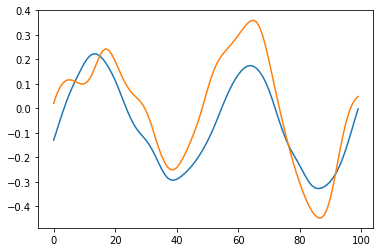

Epoch 13 - Validation loss: 0.013588231289759278: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


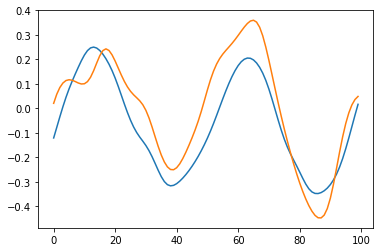

Epoch 14 - Validation loss: 0.013548575574532151: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


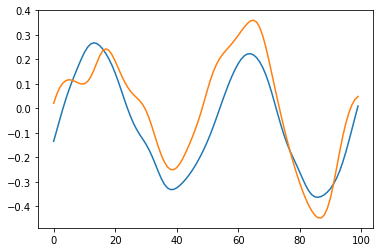

Epoch 15 - Validation loss: 0.013490017503499985: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


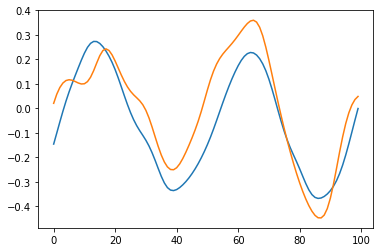

Epoch 16 - Validation loss: 0.012985649285838008: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


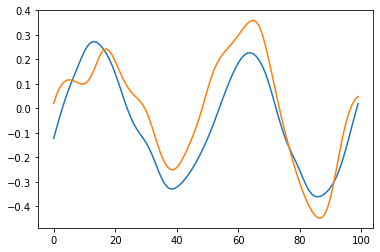

Epoch 17 - Validation loss: 0.012504342012107372: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


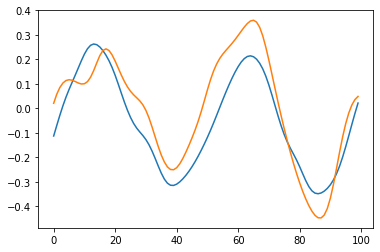

Epoch 18 - Validation loss: 0.012299939757212996: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


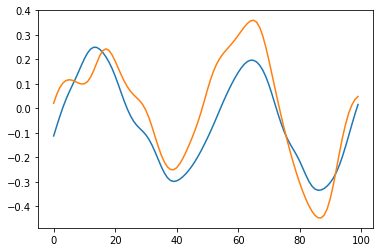

Epoch 19 - Validation loss: 0.012177743250504136: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]


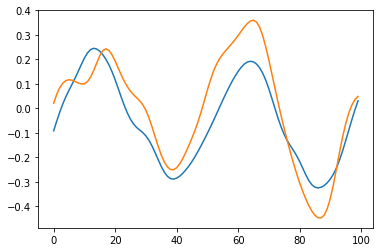

Epoch 20 - Validation loss: 0.012033808510750532: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


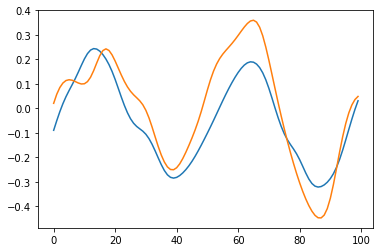

Epoch 21 - Validation loss: 0.011804223526269197: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


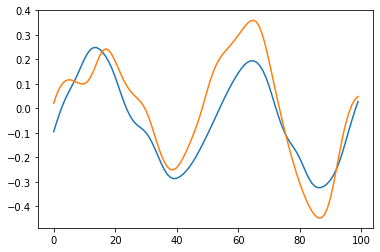

Epoch 22 - Validation loss: 0.011531497351825237: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


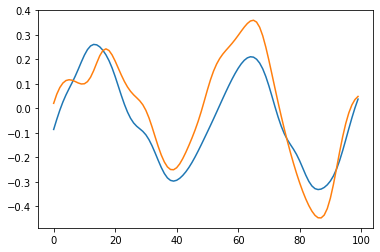

Epoch 23 - Validation loss: 0.011352778878062963: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


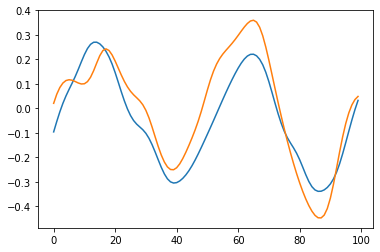

Epoch 24 - Validation loss: 0.011243518441915512: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


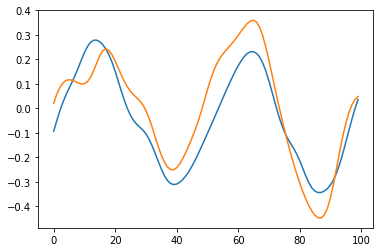

Epoch 25 - Validation loss: 0.011114474153146148: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


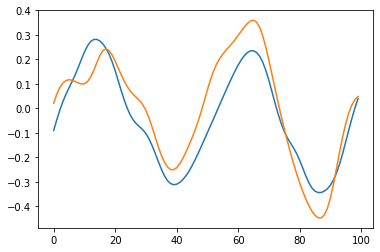

Epoch 26 - Validation loss: 0.01094993855804205: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


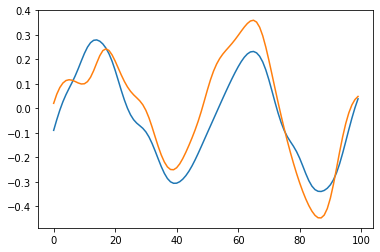

Epoch 27 - Validation loss: 0.010793412802740932: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


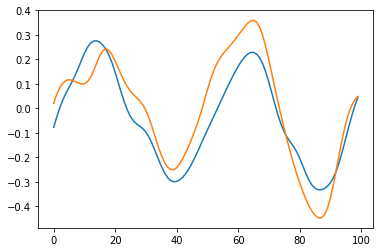

Epoch 28 - Validation loss: 0.010695406002923846: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


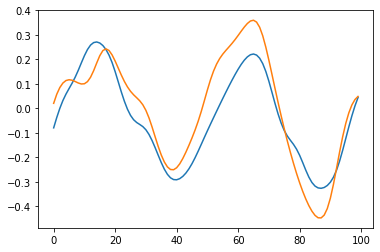

Epoch 29 - Validation loss: 0.010589987505227327: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


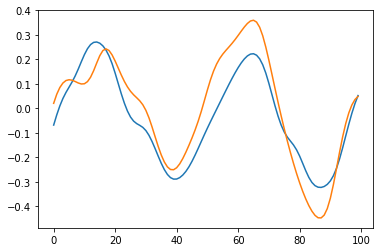

Epoch 30 - Validation loss: 0.010474449954926968: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


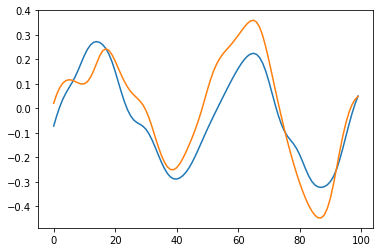

Epoch 31 - Validation loss: 0.010349806863814592: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


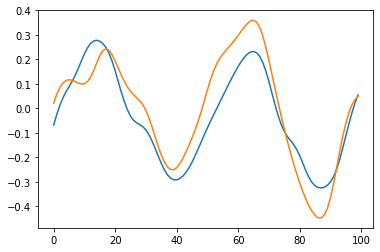

Epoch 32 - Validation loss: 0.010250984691083431: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


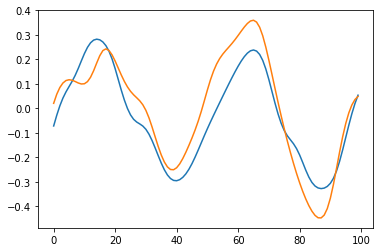

Epoch 33 - Validation loss: 0.01016368088312447: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


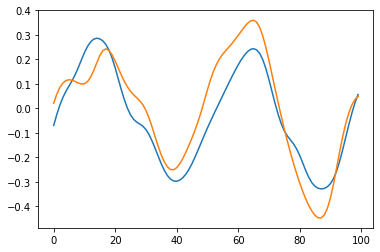

Epoch 34 - Validation loss: 0.01007571048103273: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


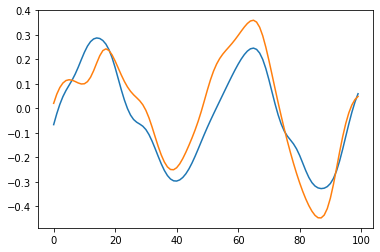

Epoch 35 - Validation loss: 0.009986689779907465: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


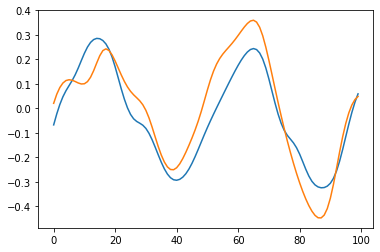

Epoch 36 - Validation loss: 0.009901772253215313: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


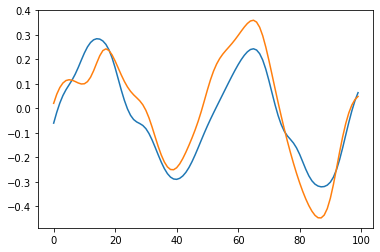

Epoch 37 - Validation loss: 0.009828784270212054: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


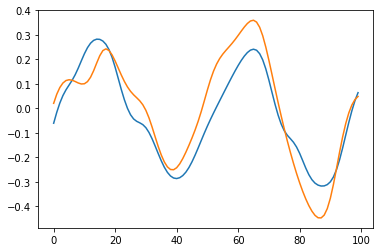

Epoch 38 - Validation loss: 0.009755139937624335: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


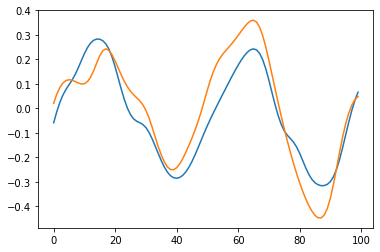

Epoch 39 - Validation loss: 0.009680205024778843: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


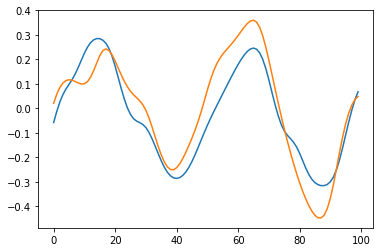

Epoch 40 - Validation loss: 0.009613211266696453: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


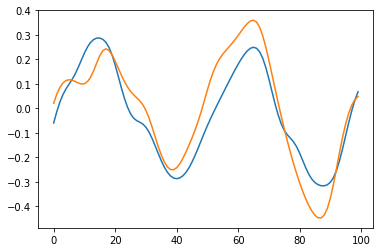

Epoch 41 - Validation loss: 0.009546713205054402: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


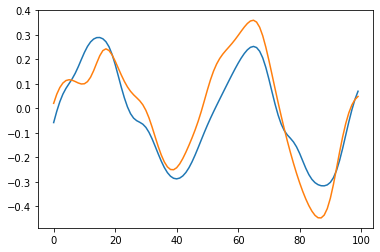

Epoch 42 - Validation loss: 0.009484385140240192: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


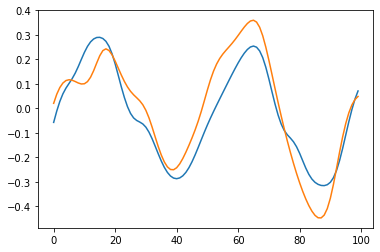

Epoch 43 - Validation loss: 0.009422224946320057: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


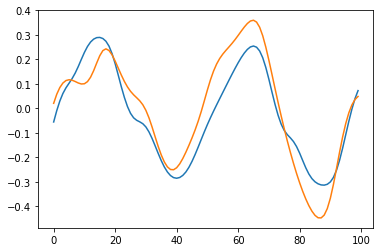

Epoch 44 - Training loss: 0.009487766772508621: 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]
Epoch 44 - Validation loss: 0.0023841976653784513:  25%|██▌       | 1/4 [00:02<00:08,  2.85s/it]


KeyboardInterrupt: ignored

In [ ]:
from tqdm import tqdm
import torch.utils.data as data



model = LMUModel().cuda()
print("\n\number of paramaters : ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("\n\n")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

dataset = torch.utils.data.TensorDataset(torch.Tensor(train_X).cuda(), torch.Tensor(train_Y).cuda())
dataset = data.DataLoader(dataset, batch_size=32, shuffle=True)

dataset_valid = torch.utils.data.TensorDataset(torch.Tensor(test_X).cuda(), torch.Tensor(test_Y).cuda())
dataset_valid = data.DataLoader(dataset_valid, batch_size=16, shuffle=False)

train(model, 100, dataset, dataset_valid)

Epoch 0 - Training loss: 0.019891606643795967:  25%|██▌       | 1/4 [00:00<00:00,  5.66it/s]


number of paramaters :  2826





Epoch 0 - Validation loss: 0.06974287144839764: 100%|██████████| 4/4 [00:00<00:00, 18.73it/s]


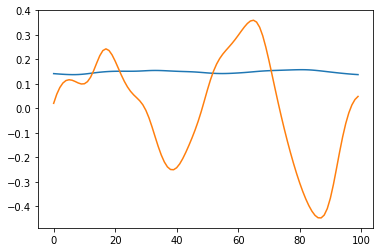

Epoch 1 - Validation loss: 0.0620333943516016: 100%|██████████| 4/4 [00:00<00:00, 18.42it/s]


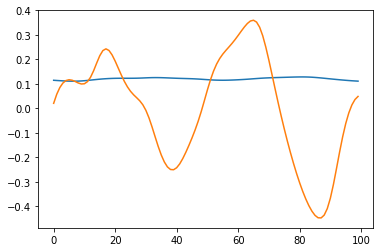

Epoch 2 - Validation loss: 0.0561963627114892: 100%|██████████| 4/4 [00:00<00:00, 17.37it/s]


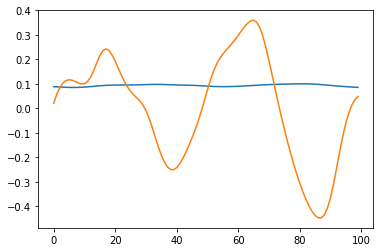

Epoch 3 - Validation loss: 0.05199812911450863: 100%|██████████| 4/4 [00:00<00:00, 17.07it/s]


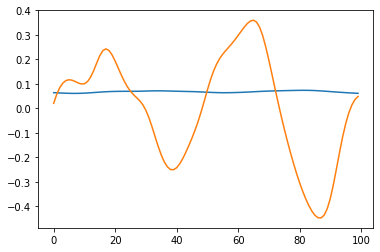

Epoch 4 - Validation loss: 0.04921770002692938: 100%|██████████| 4/4 [00:00<00:00, 18.23it/s]


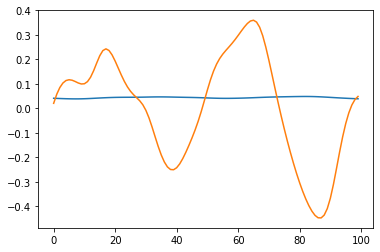

Epoch 5 - Validation loss: 0.04760617949068546: 100%|██████████| 4/4 [00:00<00:00, 17.57it/s]


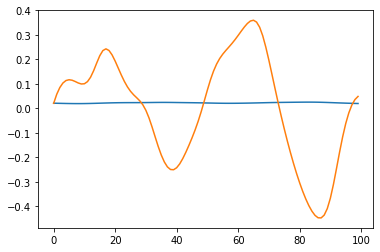

Epoch 6 - Validation loss: 0.04680423717945814: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s]


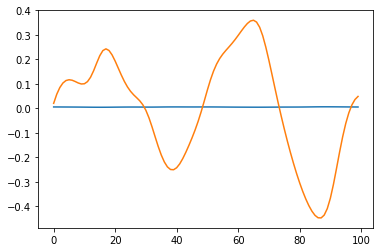

Epoch 7 - Validation loss: 0.04636743105947971: 100%|██████████| 4/4 [00:00<00:00, 18.15it/s]


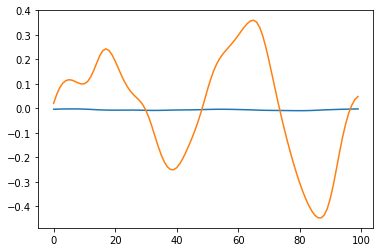

Epoch 8 - Validation loss: 0.045956170186400414: 100%|██████████| 4/4 [00:00<00:00, 17.71it/s]


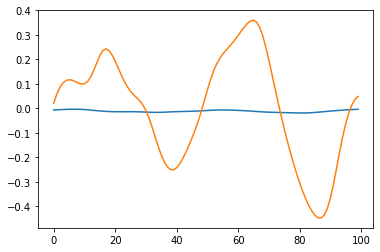

Epoch 9 - Validation loss: 0.045455772429704666: 100%|██████████| 4/4 [00:00<00:00, 17.70it/s]


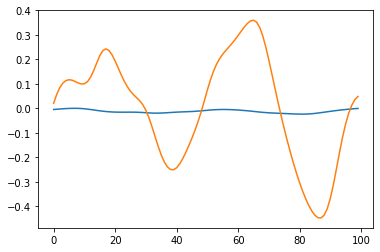

Epoch 10 - Validation loss: 0.04490710515528917: 100%|██████████| 4/4 [00:00<00:00, 18.05it/s]


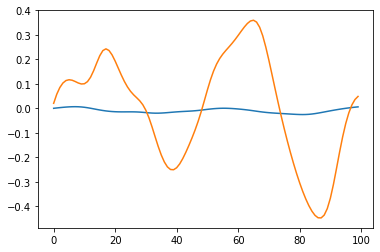

Epoch 11 - Validation loss: 0.04437370225787163: 100%|██████████| 4/4 [00:00<00:00, 17.28it/s]


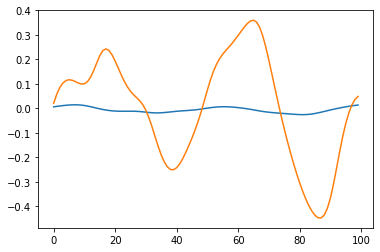

Epoch 12 - Validation loss: 0.04387266933917999: 100%|██████████| 4/4 [00:00<00:00, 17.49it/s]


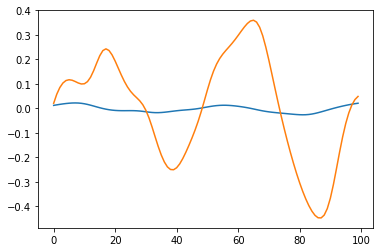

Epoch 13 - Validation loss: 0.043376329354941845: 100%|██████████| 4/4 [00:00<00:00, 16.76it/s]


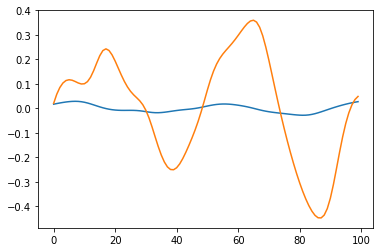

Epoch 14 - Validation loss: 0.04283936973661184: 100%|██████████| 4/4 [00:00<00:00, 15.51it/s]


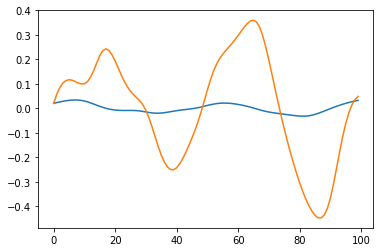

Epoch 15 - Validation loss: 0.04221871215850115: 100%|██████████| 4/4 [00:00<00:00, 17.77it/s]


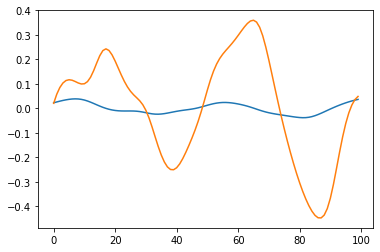

Epoch 16 - Validation loss: 0.04147746413946152: 100%|██████████| 4/4 [00:00<00:00, 15.16it/s]


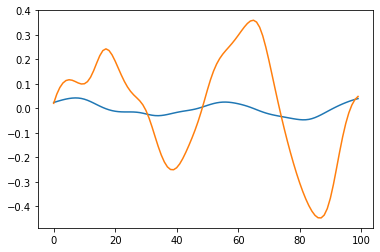

Epoch 17 - Validation loss: 0.040570491924881935: 100%|██████████| 4/4 [00:00<00:00, 14.09it/s]


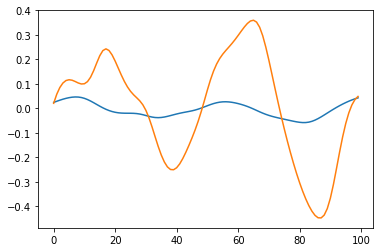

Epoch 18 - Validation loss: 0.03941821958869696: 100%|██████████| 4/4 [00:00<00:00, 14.73it/s]


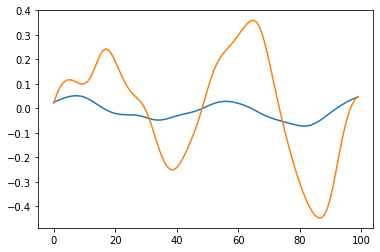

Epoch 19 - Validation loss: 0.03786777891218662: 100%|██████████| 4/4 [00:00<00:00, 16.93it/s]


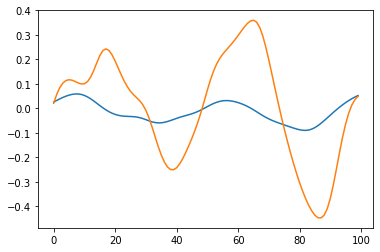

Epoch 20 - Validation loss: 0.03562931343913078: 100%|██████████| 4/4 [00:00<00:00, 13.44it/s]


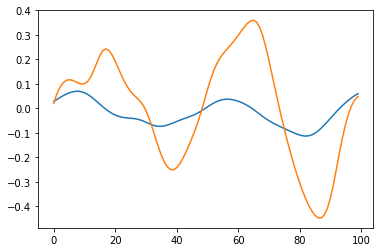

Epoch 21 - Validation loss: 0.03214511647820473: 100%|██████████| 4/4 [00:00<00:00, 13.03it/s]


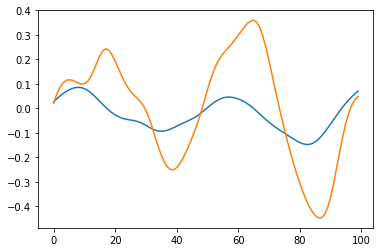

Epoch 22 - Validation loss: 0.026432161685079336: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]


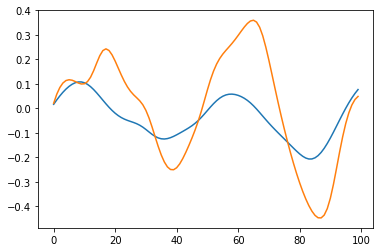

Epoch 23 - Validation loss: 0.018288088962435722: 100%|██████████| 4/4 [00:00<00:00, 15.99it/s]


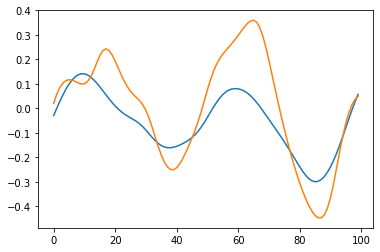

Epoch 24 - Validation loss: 0.011474131839349866: 100%|██████████| 4/4 [00:00<00:00, 13.13it/s]


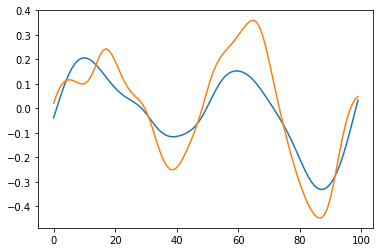

Epoch 25 - Validation loss: 0.011605133069679141: 100%|██████████| 4/4 [00:00<00:00, 16.53it/s]


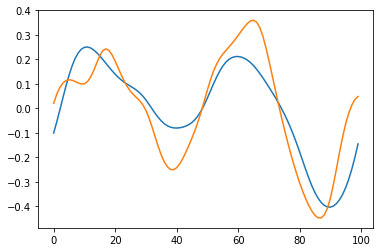

Epoch 26 - Validation loss: 0.01180633855983615: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s]


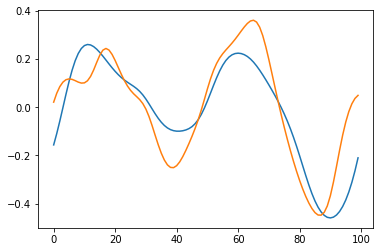

Epoch 27 - Validation loss: 0.009235696168616414: 100%|██████████| 4/4 [00:00<00:00, 15.71it/s]


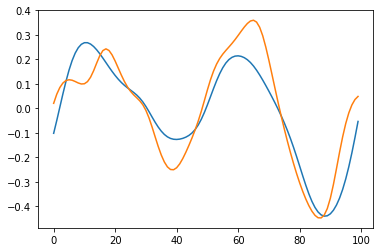

Epoch 28 - Validation loss: 0.008677974808961153: 100%|██████████| 4/4 [00:00<00:00, 14.66it/s]


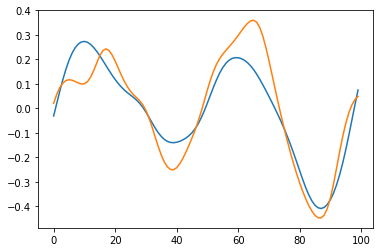

Epoch 29 - Validation loss: 0.008809611899778247: 100%|██████████| 4/4 [00:00<00:00, 15.53it/s]


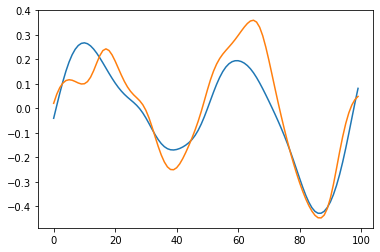

Epoch 30 - Validation loss: 0.008694165851920843: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s]


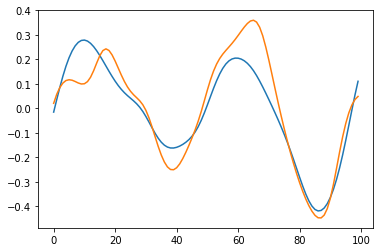

Epoch 31 - Validation loss: 0.0083485993091017: 100%|██████████| 4/4 [00:00<00:00, 15.86it/s]


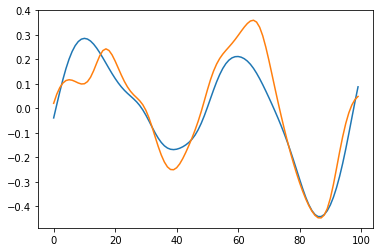

Epoch 32 - Validation loss: 0.008147625951096416: 100%|██████████| 4/4 [00:00<00:00, 16.58it/s]


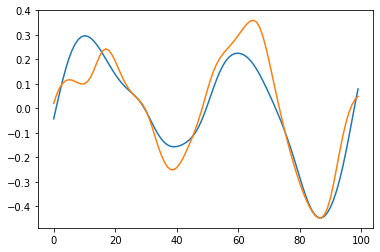

Epoch 33 - Validation loss: 0.008110536495223641: 100%|██████████| 4/4 [00:00<00:00, 15.81it/s]


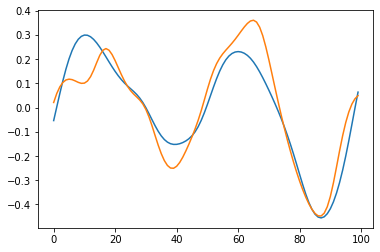

Epoch 34 - Validation loss: 0.008020358392968774: 100%|██████████| 4/4 [00:00<00:00, 13.15it/s]


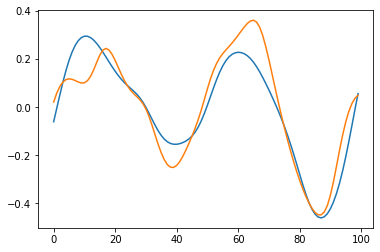

Epoch 35 - Validation loss: 0.007874740869738162: 100%|██████████| 4/4 [00:00<00:00, 13.07it/s]


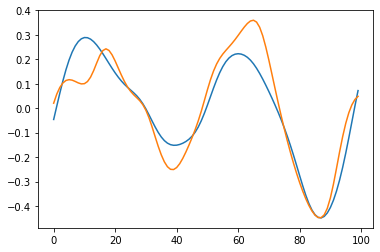

Epoch 36 - Validation loss: 0.007777345599606633: 100%|██████████| 4/4 [00:00<00:00, 16.05it/s]


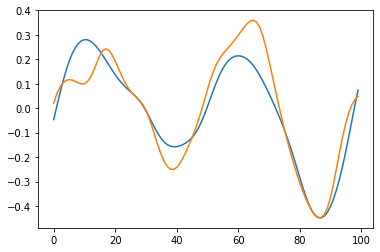

Epoch 37 - Validation loss: 0.007713904837146401: 100%|██████████| 4/4 [00:00<00:00, 12.86it/s]


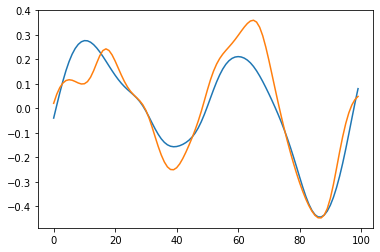

Epoch 38 - Training loss: 0.0077658339869230986: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]
Epoch 38 - Validation loss: 0.0076404152205213904: 100%|██████████| 4/4 [00:00<00:00, 13.19it/s]


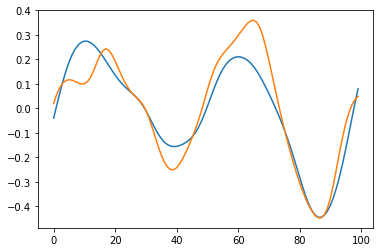

Epoch 39 - Validation loss: 0.007562744431197643: 100%|██████████| 4/4 [00:00<00:00, 15.54it/s]


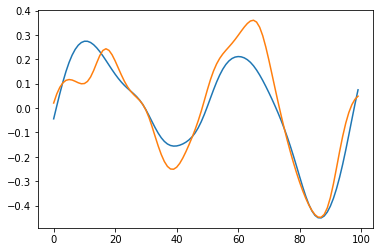

Epoch 40 - Validation loss: 0.007495321100577712: 100%|██████████| 4/4 [00:00<00:00, 12.72it/s]


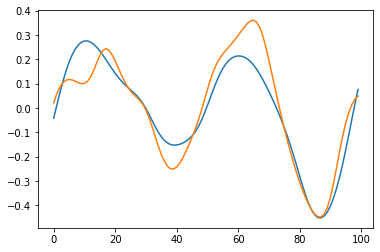

Epoch 41 - Validation loss: 0.00743044528644532: 100%|██████████| 4/4 [00:00<00:00, 15.65it/s]


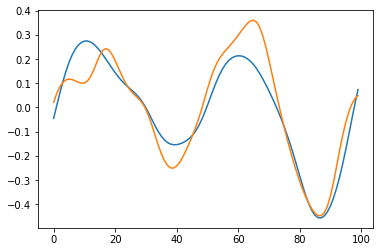

Epoch 42 - Validation loss: 0.007362545118667185: 100%|██████████| 4/4 [00:00<00:00, 15.64it/s]


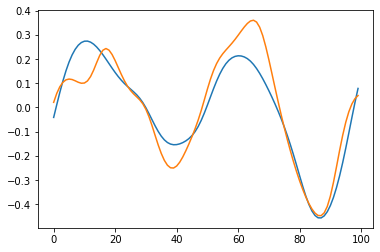

Epoch 43 - Validation loss: 0.007296341354958713: 100%|██████████| 4/4 [00:00<00:00, 15.26it/s]


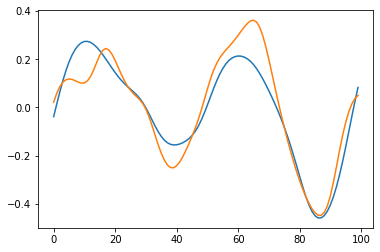

Epoch 44 - Validation loss: 0.007233557989820838: 100%|██████████| 4/4 [00:00<00:00, 13.90it/s]


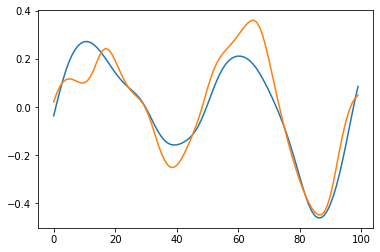

Epoch 45 - Validation loss: 0.007171558449044824: 100%|██████████| 4/4 [00:00<00:00, 15.95it/s]


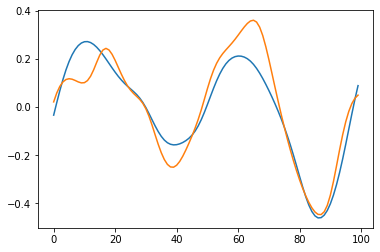

Epoch 46 - Validation loss: 0.007109978818334639: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]


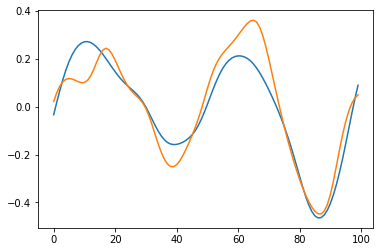

Epoch 47 - Training loss: 0.0017806910909712315:  25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]


KeyboardInterrupt: ignored

In [ ]:
from tqdm import tqdm
import torch.utils.data as data



model = LSTMModel().cuda()
print("\nnumber of paramaters : ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("\n\n")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

dataset = torch.utils.data.TensorDataset(torch.Tensor(train_X).cuda(), torch.Tensor(train_Y).cuda())
dataset = data.DataLoader(dataset, batch_size=16, shuffle=True)

dataset_valid = torch.utils.data.TensorDataset(torch.Tensor(test_X).cuda(), torch.Tensor(test_Y).cuda())
dataset_valid = data.DataLoader(dataset_valid, batch_size=16, shuffle=False)

train(model, 100, dataset, dataset_valid)